# 6.4. Imputation of missing values

For various reasons, many real world datasets contain missing values, often encoded as blanks, NaNs or other placeholders. Such datasets however are incompatible with scikit-learn estimators which assume that all values in an array are numerical, and that all have and hold meaning. A basic strategy to use incomplete datasets is to discard entire rows and/or columns containing missing values. However, this comes at the price of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values, i.e., to infer them from the known part of the data. See the Glossary of Common Terms and API Elements entry on imputation.

# 6.4.1. Univariate vs. Multivariate Imputation

One type of imputation algorithm is univariate, which imputes values in the i-th feature dimension using only non-missing values in that feature dimension (e.g. impute.SimpleImputer). By contrast, multivariate imputation algorithms use the entire set of available feature dimensions to estimate the missing values (e.g. impute.IterativeImputer).

# 6.4.2. Univariate feature imputation

The SimpleImputer class provides basic strategies for imputing missing values. Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located. This class also allows for different missing values encodings.

The following snippet demonstrates how to replace missing values, encoded as np.nan, using the mean value of the columns (axis 0) that contain the missing values:

In [14]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit([[1, 2], [np.nan, 3], [7, 6]])

X = [[np.nan, 2], [6, np.nan], [7, 6]]
print(imp.transform(X))

[[4.         2.        ]
 [6.         3.66666667]
 [7.         6.        ]]


The SimpleImputer class also supports sparse matrices:

In [15]:
import scipy.sparse as sp
X = sp.csc_matrix([[1, 2], [0, -1], [8, 4]])
imp = SimpleImputer(missing_values=-1, strategy='mean')
imp.fit(X)

X_test = sp.csc_matrix([[-1, 2], [6, -1], [7, 6]])
print(imp.transform(X_test).toarray())

[[3. 2.]
 [6. 3.]
 [7. 6.]]


Note that this format is not meant to be used to implicitly store missing values in the matrix because it would densify it at transform time. Missing values encoded by 0 must be used with dense input.

The SimpleImputer class also supports categorical data represented as string values or pandas categoricals when using the 'most_frequent' or 'constant' strategy:

In [16]:
import pandas as pd
df = pd.DataFrame([["a", "x"],
                   [np.nan, "y"],
                   ["a", np.nan],
                   ["b", "y"]], dtype="category")

imp = SimpleImputer(strategy="most_frequent")
print(imp.fit_transform(df))

[['a' 'x']
 ['a' 'y']
 ['a' 'y']
 ['b' 'y']]


# 6.4.3. Multivariate feature imputation

A more sophisticated approach is to use the IterativeImputer class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.

**Note** This estimator is still experimental for now: default parameters or details of behaviour might change without any deprecation cycle. Resolving the following issues would help stabilize IterativeImputer: convergence criteria (#14338), default estimators (#13286), and use of random state (#15611). To use it, you need to explicitly import enable_iterative_imputer.

In [17]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])

X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
# the model learns that the second feature is double the first
print(np.round(imp.transform(X_test)))

[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


Both SimpleImputer and IterativeImputer can be used in a Pipeline as a way to build a composite estimator that supports imputation. See Imputing missing values before building an estimator.

# 6.4.3.1. Flexibility of IterativeImputer
There are many well-established imputation packages in the R data science ecosystem: Amelia, mi, mice, missForest, etc. missForest is popular, and turns out to be a particular instance of different sequential imputation algorithms that can all be implemented with IterativeImputer by passing in different regressors to be used for predicting missing feature values. In the case of missForest, this regressor is a Random Forest. See Imputing missing values with variants of IterativeImputer.

# 6.4.3.2. Multiple vs. Single Imputation
In the statistics community, it is common practice to perform multiple imputations, generating, for example, m separate imputations for a single feature matrix. Each of these m imputations is then put through the subsequent analysis pipeline (e.g. feature engineering, clustering, regression, classification). The m final analysis results (e.g. held-out validation errors) allow the data scientist to obtain understanding of how analytic results may differ as a consequence of the inherent uncertainty caused by the missing values. The above practice is called multiple imputation.

Our implementation of IterativeImputer was inspired by the R MICE package (Multivariate Imputation by Chained Equations) 1, but differs from it by returning a single imputation instead of multiple imputations. However, IterativeImputer can also be used for multiple imputations by applying it repeatedly to the same dataset with different random seeds when sample_posterior=True.
It is still an open problem as to how useful single vs. multiple imputation is in the context of prediction and classification when the user is not interested in measuring uncertainty due to missing values.

Note that a call to the transform method of IterativeImputer is not allowed to change the number of samples. Therefore multiple imputations cannot be achieved by a single call to transform.

# 6.4.4. References
1
Stef van Buuren, Karin Groothuis-Oudshoorn (2011). “mice: Multivariate Imputation by Chained Equations in R”. Journal of Statistical Software 45: 1-67.

2
Roderick J A Little and Donald B Rubin (1986). “Statistical Analysis with Missing Data”. John Wiley & Sons, Inc., New York, NY, USA.

# 6.4.5. Nearest neighbors imputation
The **KNNImputer** class provides imputation for filling in missing values using the k-Nearest Neighbors approach. By default, a euclidean distance metric that supports missing values, **nan_euclidean_distances**, is used to find the nearest neighbors. Each missing feature is imputed using values from **n_neighbors** nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed. When the number of available neighbors is less than **n_neighbors** and there are no defined distances to the training set, the training set average for that feature is used during imputation. If there is at least one neighbor with a defined distance, the weighted or unweighted average of the remaining neighbors will be used during imputation. If a feature is always missing in training, it is removed during **transform**. For more information on the methodology, see ref. [OL2001].

The following snippet demonstrates how to replace missing values, encoded as np.nan, using the mean feature value of the two nearest neighbors of samples with missing values:

In [18]:
import numpy as np
from sklearn.impute import KNNImputer
nan = np.nan
X = [[1, 2, nan], [3, 4, 3], [nan, 6, 5], [8, 8, 7]]
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(X)

array([[1. , 2. , 4. ],
       [3. , 4. , 3. ],
       [5.5, 6. , 5. ],
       [8. , 8. , 7. ]])

# 6.4.6. Marking imputed values
The MissingIndicator transformer is useful to transform a dataset into corresponding binary matrix indicating the presence of missing values in the dataset. This transformation is useful in conjunction with imputation. When using imputation, preserving the information about which values had been missing can be informative. Note that both the SimpleImputer and IterativeImputer have the boolean parameter add_indicator (False by default) which when set to True provides a convenient way of stacking the output of the MissingIndicator transformer with the output of the imputer.

NaN is usually used as the placeholder for missing values. However, it enforces the data type to be float. The parameter missing_values allows to specify other placeholder such as integer. In the following example, we will use -1 as missing values:

In [6]:
from sklearn.impute import MissingIndicator
X = np.array([[-1, -1, 1, 3],
              [4, -1, 0, -1],
              [8, -1, 1, 0]])
indicator = MissingIndicator(missing_values=-1)
mask_missing_values_only = indicator.fit_transform(X)
mask_missing_values_only

array([[ True,  True, False],
       [False,  True,  True],
       [False,  True, False]])


The features parameter is used to choose the features for which the mask is constructed. By default, it is 'missing-only' which returns the imputer mask of the features containing missing values at fit time:

In [7]:
indicator.features_

array([0, 1, 3], dtype=int64)

The features parameter can be set to 'all' to return all features whether or not they contain missing values:

In [8]:
indicator = MissingIndicator(missing_values=-1, features="all")
mask_all = indicator.fit_transform(X)
mask_all

array([[ True,  True, False, False],
       [False,  True, False,  True],
       [False,  True, False, False]])

When using the MissingIndicator in a Pipeline, be sure to use the FeatureUnion or ColumnTransformer to add the indicator features to the regular features. First we obtain the iris dataset, and add some missing values to it.



In [9]:
from sklearn.datasets import load_iris
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
X, y = load_iris(return_X_y=True)
mask = np.random.randint(0, 2, size=X.shape).astype(bool)
X[mask] = np.nan
X_train, X_test, y_train, _ = train_test_split(X, y, test_size=100,
                                               random_state=0)

Now we create a FeatureUnion. All features will be imputed using SimpleImputer, in order to enable classifiers to work with this data. Additionally, it adds the indicator variables from MissingIndicator.

In [10]:
transformer = FeatureUnion(
    transformer_list=[
        ('features', SimpleImputer(strategy='mean')),
        ('indicators', MissingIndicator())])
transformer = transformer.fit(X_train, y_train)
results = transformer.transform(X_test)
results.shape


(100, 8)

Of course, we cannot use the transformer to make any predictions. We should wrap this in a Pipeline with a classifier (e.g., a DecisionTreeClassifier) to be able to make predictions.

In [11]:
>>> clf = make_pipeline(transformer, DecisionTreeClassifier())
>>> clf = clf.fit(X_train, y_train)
>>> results = clf.predict(X_test)
>>> results.shape
(100,)

(100,)

# Imputing missing values before building an estimator

Missing values can be replaced by the mean, the median or the most frequent value using the basic SimpleImputer.

In this example we will investigate different imputation techniques:

- imputation by the constant value 0

- imputation by the mean value of each feature combined with a missing-ness indicator auxiliary variable

- k nearest neighbor imputation

- iterative imputation


We will use two datasets: Diabetes dataset which consists of 10 feature variables collected from diabetes patients with an aim to predict disease progression and California Housing dataset for which the target is the median house value for California districts.

As neither of these datasets have missing values, we will remove some values to create new versions with artificially missing data. The performance of RandomForestRegressor on the full original dataset is then compared the performance on the altered datasets with the artificially missing values imputed using different techniques.

# Download the data and make missing values sets

First we download the two datasets. Diabetes dataset is shipped with scikit-learn. It has 442 entries, each with 10 features. California Housing dataset is much larger with 20640 entries and 8 features. It needs to be downloaded. We will only use the first 400 entries for the sake of speeding up the calculations but feel free to use the whole dataset.

In [29]:
import numpy as np

from sklearn.datasets import fetch_california_housing, load_diabetes

rng = np.random.RandomState(42)

X_diabetes, y_diabetes = load_diabetes(return_X_y=True)
X_california, y_california = fetch_california_housing(return_X_y=True)
X_california = X_california[:300]
y_california = y_california[:300]
X_diabetes = X_diabetes[:300]
y_diabetes = y_diabetes[:300]


def add_missing_values(X_full, y_full):
    n_samples, n_features = X_full.shape

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[:n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan
    y_missing = y_full.copy()

    return X_missing, y_missing


X_miss_california, y_miss_california = add_missing_values(X_california, y_california)

X_miss_diabetes, y_miss_diabetes = add_missing_values(X_diabetes, y_diabetes)

# Impute the missing data and score

Now we will write a function which will score the results on the differently imputed data. Let’s look at each imputer separately:

In [30]:
rng = np.random.RandomState(0)

from sklearn.ensemble import RandomForestRegressor

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

N_SPLITS = 4
regressor = RandomForestRegressor(random_state=0)

# Missing information

In addition to imputing the missing values, the imputers have an add_indicator parameter that marks the values that were missing, which might carry some information.

In [31]:
def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return impute_scores


x_labels = []

mses_california = np.zeros(5)
stds_california = np.zeros(5)
mses_diabetes = np.zeros(5)
stds_diabetes = np.zeros(5)

## Estimate the score

First, we want to estimate the score on the original data:

In [32]:
def get_full_score(X_full, y_full):
    full_scores = cross_val_score(
        regressor, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return full_scores.mean(), full_scores.std()


mses_california[0], stds_california[0] = get_full_score(X_california, y_california)
mses_diabetes[0], stds_diabetes[0] = get_full_score(X_diabetes, y_diabetes)
x_labels.append("Full data")

## Replace missing values by 0

Now we will estimate the score on the data where the missing values are replaced by 0:

In [33]:
def get_impute_zero_score(X_missing, y_missing):
    imputer = SimpleImputer(
        missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0
    )
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()


mses_california[1], stds_california[1] = get_impute_zero_score(
    X_miss_california, y_miss_california
)
mses_diabetes[1], stds_diabetes[1] = get_impute_zero_score(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("Zero imputation")

## kNN-imputation of the missing values

KNNImputer imputes missing values using the weighted or unweighted mean of the desired number of nearest neighbors.

In [34]:
def get_impute_knn_score(X_missing, y_missing):
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()


mses_california[2], stds_california[2] = get_impute_knn_score(
    X_miss_california, y_miss_california
)
mses_diabetes[2], stds_diabetes[2] = get_impute_knn_score(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("KNN Imputation")

## Impute missing values with mean

In [36]:
def get_impute_mean(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


mses_california[3], stds_california[3] = get_impute_mean(
    X_miss_california, y_miss_california
)
mses_diabetes[3], stds_diabetes[3] = get_impute_mean(X_miss_diabetes, y_miss_diabetes)
x_labels.append("Mean Imputation")

## Iterative imputation of the missing values

Another option is the IterativeImputer. This uses round-robin linear regression, modeling each feature with missing values as a function of other features, in turn. The version implemented assumes Gaussian (output) variables. If your features are obviously non-normal, consider transforming them to look more normal to potentially improve performance.

In [37]:
def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(
        missing_values=np.nan,
        add_indicator=True,
        random_state=0,
        n_nearest_features=3,
        max_iter=1,
        sample_posterior=True,
    )
    iterative_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()


mses_california[4], stds_california[4] = get_impute_iterative(
    X_miss_california, y_miss_california
)
mses_diabetes[4], stds_diabetes[4] = get_impute_iterative(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("Iterative Imputation")

mses_diabetes = mses_diabetes * -1
mses_california = mses_california * -1

### Plot the results

Finally we are going to visualize the score:

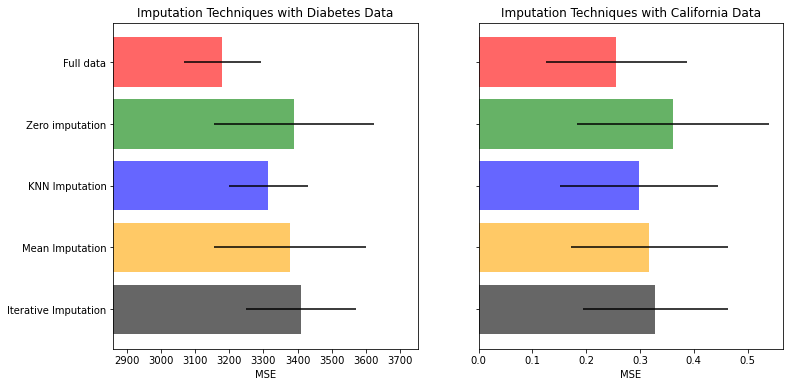

In [38]:
import matplotlib.pyplot as plt

n_bars = len(mses_diabetes)
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange", "black"]

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(
        j,
        mses_diabetes[j],
        xerr=stds_diabetes[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax1.set_title("Imputation Techniques with Diabetes Data")
ax1.set_xlim(left=np.min(mses_diabetes) * 0.9, right=np.max(mses_diabetes) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel("MSE")
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot california dataset results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(
        j,
        mses_california[j],
        xerr=stds_california[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax2.set_title("Imputation Techniques with California Data")
ax2.set_yticks(xval)
ax2.set_xlabel("MSE")
ax2.invert_yaxis()
ax2.set_yticklabels([""] * n_bars)

plt.show()
